# Neural Contextual Bandits with UCB-based Exploration
Notation:

| Notation                 | Description                                                  |
| :----------------------- | :----------------------------------------------------------- |
| $K$                      | number of arms                                               |
| $T$                      | number of total rounds                                       |
| $t$                      | index of round                                               |
| $x_{t,a}$                | $x_{t,a}\in\mathbb{R}^d$, $a\in [K]$, it is the context, the context consists of $K$ feature vectors $\{x_{t,a}\in\mathbb{R}^d|a\in[K]\}$ |
| $a_t$                    | after observes the context, the agent select an action $a_t$ in round t |
| $r_{t,a_t}$              | the reward after the agent select action $a_t$               |
| $h$                      | we assume that $r_{t,a_t}=h(x_{t,a_t})+\xi_t$, h is an unknown function satisfying $0\le h(x)\le 1$ for any x |
| $\xi_t$                  | $\xi_t$ is v-sub-Gaussian noise conditioned on $x_{1,a_1},\cdots,x_{t-1,a_{t-1}}$, satisfying $\mathbb{E}\xi_t=0$ |
| $L$                      | the depth of neural network                                  |
| $m$                      | number of neural in each layer of network                    |
| $\sigma(x)$              | we define $\sigma(x)=\max\{x,0\}$                            |
| $W_1,\cdots,W_{L-1},W_L$ | the weight in neural network. $W_1\in\mathbb{R}^{m\times d}$, $W_i\in\mathbb{R}^{m\times m}$, $2\le i\le L-1$, $W_L\in\mathbb{R}^{m\times 1}$ |
| $\theta$                 | $\theta=[vec(W_1)^T,\cdots,vec(W_l)^T]\in\mathbb{R}^p$, $p=m+md+m^2(L-1)$ |
| $f(x;\theta)$            | we define $f(x;\theta)=\sqrt{m}W_L\sigma(W_{l-1}\sigma(\cdots\sigma(W_1x)))$ |


<img src="./Figure/NeuralUCB_Initialization.png" style="zoom:80%" />

Initialization of parameters:

<img src="./Figure/NeuralUCB_Initialization.png" style="zoom:80%" />

<img src="./Figure/NeuralUCB_Initialization2.png" style="zoom:80%" />

UCB algorithm:

<img src="./Figure/NeuralUCB_Algorithm1.png" style="zoom:80%" />

<img src="./Figure/NeuralUCB_Algorithm2.png" style="zoom:80%" />

 We assume the reward follows reward = context^T * A^T * A * context + \xi
 
 $\xi$ is a random variable following standard normal distribution N(0, 1)
 
 A is d\*d matrix, randomly generated from N(0, 1)
 
 We assume the context is independent from the action and round index. 
 
 Given action a and round index t, the context is randomly sample from a unit ball in dimension d

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
type(device)

cuda:0


torch.device

In [1]:
%reset -f
import numpy as np
import random
from copy import deepcopy

from Source.agent import *
from Source.GameSetting import *

In [2]:
# Set the parameter of the game
np.random.seed(12345)
K = 4# Total number of actions, 
T = 5000 # Total number of periods
d = 4 # the dimension of context
A = np.random.normal(loc=0, scale=1, size=(d, d))

In [3]:
# Implement the algorithm
np.random.seed(12345)

# Set the parameter of the network
# the setting is based on the description of section 7.1 of the papaer
L = 2
m = 30 
# we fix gamma in each round, according to the description of section 3.1
gamma_t = 0.01 #{0.01, 0.1, 1, 10}
nu = 0.1 #{0.01, 0.1, 1}
lambda_ = 1 #{0.1, 1, 10}
delta = 0.01 #{0.01, 0.1, 1}
S = 0.01 #{0.01, 0.1, 1, 10}
eta = 1e-3 #{0.001, 0.01, 0.1}
frequency = 50
batchsize = 50
verbose = False
# we set J equal to round index t

neuralagent = NeuralAgent(
    K=K, T=T, d=d, L=L, m=m, gamma_t=gamma_t, nu=nu, lambda_=lambda_, delta=delta, S=S, eta=eta, frequency=frequency, batchsize=batchsize
)
bestagent = BestAgent(K, T, d, A)
uniformagent = UniformAgent(K, T, d)
for tt in range(1, T + 1):
    
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    realized_reward = GetRealReward(context_list, A)
    
    # neuralagent
    neural_ind = neuralagent.Action(context_list)# make a decision
    neural_reward = realized_reward[neural_ind]# play neural_ind-th arm and observe reward
    neuralagent.Update(neural_reward)
    
    # bestagent
    best_ind = bestagent.Action(context_list)# make a decision
    best_reward = realized_reward[best_ind]# play best_ind-th arm and observe reward
    bestagent.Update(best_reward)
    
    # uniformagent
    uniform_ind = uniformagent.Action(context_list)# make a decision
    uniform_reward = realized_reward[uniform_ind]# play uniform_ind-th arm and observe reward
    uniformagent.Update(uniform_reward)
    
    print("round index {:d}; neural choose {:d}, reward is {:f}; best choose {:d}, reward is {:f}".format(tt,
                                                                                                          neural_ind,
                                                                                                          neural_reward,
                                                                                                          best_ind,
                                                                                                          best_reward,))

Using device cuda:0
round index 1; neural choose 3, reward is 6.666776; best choose 3, reward is 6.666776
round index 2; neural choose 3, reward is 5.186151; best choose 2, reward is 5.908255
round index 3; neural choose 3, reward is 6.140475; best choose 0, reward is 6.648616
round index 4; neural choose 3, reward is 6.597986; best choose 2, reward is 6.691268
round index 5; neural choose 3, reward is 3.298056; best choose 0, reward is 4.934174
round index 6; neural choose 3, reward is 5.176071; best choose 1, reward is 6.128102
round index 7; neural choose 2, reward is 6.796975; best choose 2, reward is 6.796975
round index 8; neural choose 2, reward is 3.449769; best choose 3, reward is 6.706144
round index 9; neural choose 1, reward is 0.587056; best choose 3, reward is 6.086979
round index 10; neural choose 2, reward is 1.360722; best choose 1, reward is 6.629483
round index 11; neural choose 3, reward is 1.822996; best choose 2, reward is 5.535969
round index 12; neural choose 3,

40 training epoch, mean loss value is 3.813659825126934
60 training epoch, mean loss value is 2.9226435399630493
80 training epoch, mean loss value is 2.0138989023841667
round index 100; neural choose 3, reward is 6.184964; best choose 2, reward is 6.618353
round index 101; neural choose 0, reward is 6.682393; best choose 2, reward is 6.732616
round index 102; neural choose 3, reward is 3.740902; best choose 3, reward is 3.740902
round index 103; neural choose 0, reward is 6.576917; best choose 0, reward is 6.576917
round index 104; neural choose 2, reward is 6.306176; best choose 2, reward is 6.306176
round index 105; neural choose 2, reward is 2.811051; best choose 1, reward is 5.362147
round index 106; neural choose 0, reward is 4.852959; best choose 3, reward is 5.371008
round index 107; neural choose 1, reward is 6.527557; best choose 1, reward is 6.527557
round index 108; neural choose 2, reward is 6.540652; best choose 2, reward is 6.540652
round index 109; neural choose 2, rewa

20 training epoch, mean loss value is 4.170316466696134
40 training epoch, mean loss value is 0.8662691558093482
60 training epoch, mean loss value is 0.19239525339975425
80 training epoch, mean loss value is 0.06580199228649986
100 training epoch, mean loss value is 0.031561951314214236
round index 200; neural choose 1, reward is 5.937583; best choose 1, reward is 5.937583
round index 201; neural choose 0, reward is 6.484309; best choose 0, reward is 6.484309
round index 202; neural choose 3, reward is 6.669389; best choose 3, reward is 6.669389
round index 203; neural choose 0, reward is 6.536576; best choose 0, reward is 6.536576
round index 204; neural choose 0, reward is 6.530319; best choose 0, reward is 6.530319
round index 205; neural choose 3, reward is 6.697681; best choose 3, reward is 6.697681
round index 206; neural choose 0, reward is 6.052770; best choose 0, reward is 6.052770
round index 207; neural choose 2, reward is 5.765993; best choose 2, reward is 5.765993
round i

round index 291; neural choose 1, reward is 6.459868; best choose 1, reward is 6.459868
round index 292; neural choose 2, reward is 6.197041; best choose 0, reward is 6.173544
round index 293; neural choose 3, reward is 6.812395; best choose 3, reward is 6.812395
round index 294; neural choose 0, reward is 6.702880; best choose 0, reward is 6.702880
round index 295; neural choose 1, reward is 6.099623; best choose 1, reward is 6.099623
round index 296; neural choose 3, reward is 3.629030; best choose 3, reward is 3.629030
round index 297; neural choose 1, reward is 6.607075; best choose 1, reward is 6.607075
round index 298; neural choose 0, reward is 4.343142; best choose 0, reward is 4.343142
round index 299; neural choose 2, reward is 6.787281; best choose 2, reward is 6.787281
20 training epoch, mean loss value is 0.7913986055152384
40 training epoch, mean loss value is 0.14050926799609212
60 training epoch, mean loss value is 0.04669956301882635
80 training epoch, mean loss value 

round index 385; neural choose 2, reward is 6.498050; best choose 2, reward is 6.498050
round index 386; neural choose 2, reward is 6.705942; best choose 2, reward is 6.705942
round index 387; neural choose 2, reward is 6.648405; best choose 2, reward is 6.648405
round index 388; neural choose 0, reward is 6.097201; best choose 0, reward is 6.097201
round index 389; neural choose 0, reward is 4.294588; best choose 0, reward is 4.294588
round index 390; neural choose 1, reward is 6.749153; best choose 1, reward is 6.749153
round index 391; neural choose 2, reward is 4.177194; best choose 2, reward is 4.177194
round index 392; neural choose 3, reward is 4.966531; best choose 3, reward is 4.966531
round index 393; neural choose 2, reward is 6.614273; best choose 2, reward is 6.614273
round index 394; neural choose 0, reward is 2.714305; best choose 0, reward is 2.714305
round index 395; neural choose 1, reward is 6.335435; best choose 1, reward is 6.335435
round index 396; neural choose 3

round index 485; neural choose 3, reward is 5.180106; best choose 3, reward is 5.180106
round index 486; neural choose 0, reward is 5.779549; best choose 0, reward is 5.779549
round index 487; neural choose 1, reward is 6.724821; best choose 1, reward is 6.724821
round index 488; neural choose 1, reward is 6.377381; best choose 1, reward is 6.377381
round index 489; neural choose 1, reward is 6.737988; best choose 1, reward is 6.737988
round index 490; neural choose 3, reward is 6.134543; best choose 3, reward is 6.134543
round index 491; neural choose 3, reward is 6.037774; best choose 3, reward is 6.037774
round index 492; neural choose 0, reward is 6.676843; best choose 0, reward is 6.676843
round index 493; neural choose 0, reward is 6.775494; best choose 0, reward is 6.775494
round index 494; neural choose 3, reward is 6.350762; best choose 3, reward is 6.350762
round index 495; neural choose 2, reward is 6.475480; best choose 2, reward is 6.475480
round index 496; neural choose 0

round index 592; neural choose 3, reward is 6.120471; best choose 3, reward is 6.120471
round index 593; neural choose 1, reward is 6.456709; best choose 1, reward is 6.456709
round index 594; neural choose 3, reward is 3.918167; best choose 3, reward is 3.918167
round index 595; neural choose 1, reward is 6.599872; best choose 1, reward is 6.599872
round index 596; neural choose 3, reward is 5.163669; best choose 3, reward is 5.163669
round index 597; neural choose 2, reward is 5.464554; best choose 2, reward is 5.464554
round index 598; neural choose 1, reward is 6.768897; best choose 1, reward is 6.768897
round index 599; neural choose 1, reward is 6.750021; best choose 1, reward is 6.750021
20 training epoch, mean loss value is 0.19625845929203778
40 training epoch, mean loss value is 0.04370247176365385
60 training epoch, mean loss value is 0.02089267344410772
80 training epoch, mean loss value is 0.015911027913231884
100 training epoch, mean loss value is 0.014044796088693292
rou

round index 681; neural choose 1, reward is 2.809438; best choose 1, reward is 2.809438
round index 682; neural choose 3, reward is 6.573323; best choose 3, reward is 6.573323
round index 683; neural choose 2, reward is 6.289277; best choose 2, reward is 6.289277
round index 684; neural choose 0, reward is 6.680703; best choose 0, reward is 6.680703
round index 685; neural choose 2, reward is 6.741370; best choose 2, reward is 6.741370
round index 686; neural choose 3, reward is 6.283117; best choose 3, reward is 6.283117
round index 687; neural choose 2, reward is 6.701149; best choose 2, reward is 6.701149
round index 688; neural choose 1, reward is 6.704330; best choose 1, reward is 6.704330
round index 689; neural choose 1, reward is 6.498532; best choose 1, reward is 6.498532
round index 690; neural choose 0, reward is 6.447600; best choose 0, reward is 6.447600
round index 691; neural choose 1, reward is 4.314918; best choose 1, reward is 4.314918
round index 692; neural choose 2

round index 770; neural choose 2, reward is 6.743774; best choose 2, reward is 6.743774
round index 771; neural choose 1, reward is 4.259605; best choose 1, reward is 4.259605
round index 772; neural choose 2, reward is 6.430490; best choose 2, reward is 6.430490
round index 773; neural choose 2, reward is 6.767699; best choose 2, reward is 6.767699
round index 774; neural choose 2, reward is 6.286505; best choose 2, reward is 6.286505
round index 775; neural choose 2, reward is 0.893218; best choose 2, reward is 0.893218
round index 776; neural choose 3, reward is 5.349886; best choose 3, reward is 5.349886
round index 777; neural choose 2, reward is 6.799712; best choose 2, reward is 6.799712
round index 778; neural choose 3, reward is 6.533822; best choose 3, reward is 6.533822
round index 779; neural choose 3, reward is 6.821645; best choose 3, reward is 6.821645
round index 780; neural choose 3, reward is 2.452343; best choose 3, reward is 2.452343
round index 781; neural choose 2

round index 871; neural choose 0, reward is 5.188005; best choose 0, reward is 5.188005
round index 872; neural choose 2, reward is 6.690033; best choose 2, reward is 6.690033
round index 873; neural choose 2, reward is 6.763674; best choose 2, reward is 6.763674
round index 874; neural choose 2, reward is 5.898056; best choose 2, reward is 5.898056
round index 875; neural choose 1, reward is 6.357711; best choose 1, reward is 6.357711
round index 876; neural choose 0, reward is 6.773911; best choose 0, reward is 6.773911
round index 877; neural choose 3, reward is 2.537395; best choose 3, reward is 2.537395
round index 878; neural choose 3, reward is 6.559972; best choose 3, reward is 6.559972
round index 879; neural choose 0, reward is 6.471659; best choose 0, reward is 6.471659
round index 880; neural choose 3, reward is 6.697652; best choose 3, reward is 6.697652
round index 881; neural choose 3, reward is 5.100245; best choose 3, reward is 5.100245
round index 882; neural choose 1

round index 970; neural choose 2, reward is 4.139943; best choose 2, reward is 4.139943
round index 971; neural choose 3, reward is 6.362128; best choose 3, reward is 6.362128
round index 972; neural choose 2, reward is 5.132414; best choose 2, reward is 5.132414
round index 973; neural choose 1, reward is 4.373457; best choose 1, reward is 4.373457
round index 974; neural choose 3, reward is 6.708125; best choose 3, reward is 6.708125
round index 975; neural choose 3, reward is 5.396246; best choose 3, reward is 5.396246
round index 976; neural choose 0, reward is 6.635648; best choose 1, reward is 6.720039
round index 977; neural choose 2, reward is 6.322865; best choose 2, reward is 6.322865
round index 978; neural choose 0, reward is 6.453152; best choose 0, reward is 6.453152
round index 979; neural choose 2, reward is 6.707795; best choose 2, reward is 6.707795
round index 980; neural choose 1, reward is 6.523047; best choose 1, reward is 6.523047
round index 981; neural choose 2

round index 1070; neural choose 2, reward is 5.407344; best choose 2, reward is 5.407344
round index 1071; neural choose 0, reward is 6.529650; best choose 0, reward is 6.529650
round index 1072; neural choose 0, reward is 6.630451; best choose 0, reward is 6.630451
round index 1073; neural choose 0, reward is 6.486166; best choose 0, reward is 6.486166
round index 1074; neural choose 1, reward is 6.282747; best choose 1, reward is 6.282747
round index 1075; neural choose 0, reward is 5.999120; best choose 0, reward is 5.999120
round index 1076; neural choose 0, reward is 4.667930; best choose 0, reward is 4.667930
round index 1077; neural choose 2, reward is 6.024225; best choose 2, reward is 6.024225
round index 1078; neural choose 2, reward is 6.404753; best choose 2, reward is 6.404753
round index 1079; neural choose 3, reward is 5.769856; best choose 3, reward is 5.769856
round index 1080; neural choose 3, reward is 6.309924; best choose 3, reward is 6.309924
round index 1081; neu

round index 1170; neural choose 1, reward is 6.779722; best choose 1, reward is 6.779722
round index 1171; neural choose 1, reward is 6.616486; best choose 1, reward is 6.616486
round index 1172; neural choose 2, reward is 6.779291; best choose 2, reward is 6.779291
round index 1173; neural choose 1, reward is 4.143000; best choose 1, reward is 4.143000
round index 1174; neural choose 2, reward is 4.484047; best choose 2, reward is 4.484047
round index 1175; neural choose 1, reward is 6.682665; best choose 1, reward is 6.682665
round index 1176; neural choose 0, reward is 6.711607; best choose 0, reward is 6.711607
round index 1177; neural choose 2, reward is 6.702205; best choose 2, reward is 6.702205
round index 1178; neural choose 2, reward is 6.136573; best choose 2, reward is 6.136573
round index 1179; neural choose 3, reward is 5.763842; best choose 3, reward is 5.763842
round index 1180; neural choose 1, reward is 4.184634; best choose 1, reward is 4.184634
round index 1181; neu

round index 1270; neural choose 1, reward is 6.676621; best choose 1, reward is 6.676621
round index 1271; neural choose 1, reward is 3.261258; best choose 1, reward is 3.261258
round index 1272; neural choose 3, reward is 5.680408; best choose 3, reward is 5.680408
round index 1273; neural choose 1, reward is 5.924591; best choose 1, reward is 5.924591
round index 1274; neural choose 1, reward is 1.885874; best choose 1, reward is 1.885874
round index 1275; neural choose 1, reward is 6.736556; best choose 1, reward is 6.736556
round index 1276; neural choose 2, reward is 6.705206; best choose 2, reward is 6.705206
round index 1277; neural choose 2, reward is 6.306711; best choose 2, reward is 6.306711
round index 1278; neural choose 2, reward is 6.699262; best choose 2, reward is 6.699262
round index 1279; neural choose 1, reward is 3.264121; best choose 1, reward is 3.264121
round index 1280; neural choose 3, reward is 5.015593; best choose 3, reward is 5.015593
round index 1281; neu

round index 1371; neural choose 1, reward is 5.712767; best choose 1, reward is 5.712767
round index 1372; neural choose 1, reward is 6.741124; best choose 1, reward is 6.741124
round index 1373; neural choose 1, reward is 6.615454; best choose 1, reward is 6.615454
round index 1374; neural choose 2, reward is 6.680018; best choose 2, reward is 6.680018
round index 1375; neural choose 3, reward is 2.528728; best choose 3, reward is 2.528728
round index 1376; neural choose 1, reward is 6.005840; best choose 1, reward is 6.005840
round index 1377; neural choose 1, reward is 6.580246; best choose 1, reward is 6.580246
round index 1378; neural choose 1, reward is 4.051527; best choose 1, reward is 4.051527
round index 1379; neural choose 2, reward is 5.613337; best choose 2, reward is 5.613337
round index 1380; neural choose 0, reward is 6.498457; best choose 0, reward is 6.498457
round index 1381; neural choose 1, reward is 3.982883; best choose 1, reward is 3.982883
round index 1382; neu

round index 1468; neural choose 1, reward is 5.574445; best choose 1, reward is 5.574445
round index 1469; neural choose 1, reward is 6.282744; best choose 1, reward is 6.282744
round index 1470; neural choose 2, reward is 6.051228; best choose 2, reward is 6.051228
round index 1471; neural choose 1, reward is 6.429833; best choose 1, reward is 6.429833
round index 1472; neural choose 1, reward is 5.549956; best choose 1, reward is 5.549956
round index 1473; neural choose 2, reward is 6.714026; best choose 2, reward is 6.714026
round index 1474; neural choose 1, reward is 3.828558; best choose 1, reward is 3.828558
round index 1475; neural choose 1, reward is 5.799592; best choose 1, reward is 5.799592
round index 1476; neural choose 1, reward is 2.709330; best choose 1, reward is 2.709330
round index 1477; neural choose 3, reward is 6.751097; best choose 3, reward is 6.751097
round index 1478; neural choose 3, reward is 5.989545; best choose 3, reward is 5.989545
round index 1479; neu

round index 1570; neural choose 0, reward is 6.734021; best choose 0, reward is 6.734021
round index 1571; neural choose 1, reward is 2.328533; best choose 1, reward is 2.328533
round index 1572; neural choose 0, reward is 5.681470; best choose 0, reward is 5.681470
round index 1573; neural choose 0, reward is 6.746614; best choose 0, reward is 6.746614
round index 1574; neural choose 1, reward is 6.713648; best choose 1, reward is 6.713648
round index 1575; neural choose 1, reward is 6.751522; best choose 1, reward is 6.751522
round index 1576; neural choose 1, reward is 6.720286; best choose 1, reward is 6.720286
round index 1577; neural choose 2, reward is 6.725288; best choose 2, reward is 6.725288
round index 1578; neural choose 0, reward is 5.811864; best choose 0, reward is 5.811864
round index 1579; neural choose 0, reward is 6.281099; best choose 0, reward is 6.281099
round index 1580; neural choose 3, reward is 6.635619; best choose 3, reward is 6.635619
round index 1581; neu

round index 1671; neural choose 0, reward is 6.126258; best choose 0, reward is 6.126258
round index 1672; neural choose 0, reward is 6.642209; best choose 0, reward is 6.642209
round index 1673; neural choose 0, reward is 6.155668; best choose 0, reward is 6.155668
round index 1674; neural choose 0, reward is 4.842010; best choose 0, reward is 4.842010
round index 1675; neural choose 2, reward is 6.273950; best choose 2, reward is 6.273950
round index 1676; neural choose 3, reward is 6.474076; best choose 3, reward is 6.474076
round index 1677; neural choose 1, reward is 6.598448; best choose 1, reward is 6.598448
round index 1678; neural choose 0, reward is 1.632857; best choose 0, reward is 1.632857
round index 1679; neural choose 0, reward is 6.547581; best choose 0, reward is 6.547581
round index 1680; neural choose 0, reward is 6.743028; best choose 0, reward is 6.743028
round index 1681; neural choose 3, reward is 6.771486; best choose 3, reward is 6.771486
round index 1682; neu

round index 1771; neural choose 1, reward is 6.721051; best choose 1, reward is 6.721051
round index 1772; neural choose 0, reward is 5.419261; best choose 0, reward is 5.419261
round index 1773; neural choose 0, reward is 5.148390; best choose 0, reward is 5.148390
round index 1774; neural choose 3, reward is 5.085188; best choose 3, reward is 5.085188
round index 1775; neural choose 1, reward is 6.688022; best choose 1, reward is 6.688022
round index 1776; neural choose 2, reward is 4.879861; best choose 1, reward is 4.987856
round index 1777; neural choose 0, reward is 4.838794; best choose 0, reward is 4.838794
round index 1778; neural choose 0, reward is 5.488826; best choose 0, reward is 5.488826
round index 1779; neural choose 1, reward is 6.434486; best choose 1, reward is 6.434486
round index 1780; neural choose 2, reward is 6.031280; best choose 2, reward is 6.031280
round index 1781; neural choose 2, reward is 6.643697; best choose 2, reward is 6.643697
round index 1782; neu

round index 1871; neural choose 1, reward is 6.624917; best choose 1, reward is 6.624917
round index 1872; neural choose 0, reward is 6.519651; best choose 0, reward is 6.519651
round index 1873; neural choose 2, reward is 1.524129; best choose 3, reward is 1.689061
round index 1874; neural choose 2, reward is 6.705155; best choose 2, reward is 6.705155
round index 1875; neural choose 2, reward is 6.669385; best choose 2, reward is 6.669385
round index 1876; neural choose 3, reward is 6.337927; best choose 3, reward is 6.337927
round index 1877; neural choose 2, reward is 5.711993; best choose 2, reward is 5.711993
round index 1878; neural choose 0, reward is 4.943609; best choose 0, reward is 4.943609
round index 1879; neural choose 2, reward is 4.279545; best choose 2, reward is 4.279545
round index 1880; neural choose 0, reward is 5.800871; best choose 0, reward is 5.800871
round index 1881; neural choose 1, reward is 4.122395; best choose 1, reward is 4.122395
round index 1882; neu

round index 1971; neural choose 2, reward is 5.675541; best choose 2, reward is 5.675541
round index 1972; neural choose 2, reward is 6.307447; best choose 2, reward is 6.307447
round index 1973; neural choose 2, reward is 6.751539; best choose 2, reward is 6.751539
round index 1974; neural choose 1, reward is 6.437056; best choose 1, reward is 6.437056
round index 1975; neural choose 2, reward is 6.336146; best choose 2, reward is 6.336146
round index 1976; neural choose 1, reward is 5.293387; best choose 1, reward is 5.293387
round index 1977; neural choose 0, reward is 5.107484; best choose 0, reward is 5.107484
round index 1978; neural choose 0, reward is 6.726051; best choose 0, reward is 6.726051
round index 1979; neural choose 2, reward is 5.971048; best choose 2, reward is 5.971048
round index 1980; neural choose 1, reward is 6.486653; best choose 1, reward is 6.486653
round index 1981; neural choose 2, reward is 6.448732; best choose 2, reward is 6.448732
round index 1982; neu

round index 2071; neural choose 2, reward is 6.697396; best choose 2, reward is 6.697396
round index 2072; neural choose 2, reward is 6.732209; best choose 2, reward is 6.732209
round index 2073; neural choose 3, reward is 6.651254; best choose 3, reward is 6.651254
round index 2074; neural choose 3, reward is 6.156348; best choose 3, reward is 6.156348
round index 2075; neural choose 1, reward is 3.576247; best choose 1, reward is 3.576247
round index 2076; neural choose 3, reward is 6.132263; best choose 3, reward is 6.132263
round index 2077; neural choose 2, reward is 6.667583; best choose 2, reward is 6.667583
round index 2078; neural choose 0, reward is 5.015996; best choose 0, reward is 5.015996
round index 2079; neural choose 1, reward is 6.605462; best choose 1, reward is 6.605462
round index 2080; neural choose 3, reward is 5.288372; best choose 3, reward is 5.288372
round index 2081; neural choose 2, reward is 4.829813; best choose 2, reward is 4.829813
round index 2082; neu

round index 2171; neural choose 1, reward is 5.790071; best choose 1, reward is 5.790071
round index 2172; neural choose 3, reward is 6.336836; best choose 3, reward is 6.336836
round index 2173; neural choose 0, reward is 6.080637; best choose 0, reward is 6.080637
round index 2174; neural choose 3, reward is 6.143736; best choose 3, reward is 6.143736
round index 2175; neural choose 2, reward is 3.774623; best choose 2, reward is 3.774623
round index 2176; neural choose 3, reward is 6.358374; best choose 3, reward is 6.358374
round index 2177; neural choose 3, reward is 5.899664; best choose 3, reward is 5.899664
round index 2178; neural choose 2, reward is 6.659105; best choose 2, reward is 6.659105
round index 2179; neural choose 3, reward is 6.044369; best choose 3, reward is 6.044369
round index 2180; neural choose 1, reward is 6.142684; best choose 1, reward is 6.142684
round index 2181; neural choose 3, reward is 6.786073; best choose 2, reward is 6.750822
round index 2182; neu

round index 2271; neural choose 1, reward is 6.495378; best choose 1, reward is 6.495378
round index 2272; neural choose 1, reward is 5.008157; best choose 1, reward is 5.008157
round index 2273; neural choose 1, reward is 6.410521; best choose 1, reward is 6.410521
round index 2274; neural choose 1, reward is 5.783268; best choose 1, reward is 5.783268
round index 2275; neural choose 2, reward is 6.733829; best choose 2, reward is 6.733829
round index 2276; neural choose 1, reward is 6.550709; best choose 1, reward is 6.550709
round index 2277; neural choose 2, reward is 4.434735; best choose 2, reward is 4.434735
round index 2278; neural choose 2, reward is 6.365186; best choose 2, reward is 6.365186
round index 2279; neural choose 3, reward is 6.166014; best choose 3, reward is 6.166014
round index 2280; neural choose 2, reward is 3.012047; best choose 2, reward is 3.012047
round index 2281; neural choose 1, reward is 5.822622; best choose 1, reward is 5.822622
round index 2282; neu

round index 2372; neural choose 0, reward is 4.437154; best choose 0, reward is 4.437154
round index 2373; neural choose 2, reward is 4.079376; best choose 2, reward is 4.079376
round index 2374; neural choose 2, reward is 6.671923; best choose 2, reward is 6.671923
round index 2375; neural choose 1, reward is 6.700401; best choose 1, reward is 6.700401
round index 2376; neural choose 1, reward is 6.676226; best choose 1, reward is 6.676226
round index 2377; neural choose 3, reward is 5.505019; best choose 3, reward is 5.505019
round index 2378; neural choose 1, reward is 6.573802; best choose 1, reward is 6.573802
round index 2379; neural choose 0, reward is 6.279585; best choose 0, reward is 6.279585
round index 2380; neural choose 2, reward is 2.247728; best choose 2, reward is 2.247728
round index 2381; neural choose 2, reward is 5.736052; best choose 2, reward is 5.736052
round index 2382; neural choose 1, reward is 6.503380; best choose 1, reward is 6.503380
round index 2383; neu

round index 2471; neural choose 0, reward is 6.042647; best choose 0, reward is 6.042647
round index 2472; neural choose 1, reward is 6.251327; best choose 1, reward is 6.251327
round index 2473; neural choose 3, reward is 5.023867; best choose 3, reward is 5.023867
round index 2474; neural choose 1, reward is 6.590907; best choose 1, reward is 6.590907
round index 2475; neural choose 0, reward is 5.879700; best choose 0, reward is 5.879700
round index 2476; neural choose 0, reward is 5.555174; best choose 0, reward is 5.555174
round index 2477; neural choose 3, reward is 2.893182; best choose 3, reward is 2.893182
round index 2478; neural choose 3, reward is 5.039771; best choose 3, reward is 5.039771
round index 2479; neural choose 1, reward is 6.743461; best choose 1, reward is 6.743461
round index 2480; neural choose 0, reward is 6.605480; best choose 0, reward is 6.605480
round index 2481; neural choose 1, reward is 4.521940; best choose 1, reward is 4.521940
round index 2482; neu

round index 2570; neural choose 2, reward is 6.688524; best choose 2, reward is 6.688524
round index 2571; neural choose 0, reward is 6.074404; best choose 0, reward is 6.074404
round index 2572; neural choose 0, reward is 5.631842; best choose 0, reward is 5.631842
round index 2573; neural choose 0, reward is 3.571900; best choose 0, reward is 3.571900
round index 2574; neural choose 0, reward is 5.423765; best choose 0, reward is 5.423765
round index 2575; neural choose 3, reward is 6.188314; best choose 3, reward is 6.188314
round index 2576; neural choose 2, reward is 5.781647; best choose 2, reward is 5.781647
round index 2577; neural choose 3, reward is 6.774345; best choose 3, reward is 6.774345
round index 2578; neural choose 3, reward is 3.142301; best choose 3, reward is 3.142301
round index 2579; neural choose 0, reward is 6.057244; best choose 0, reward is 6.057244
round index 2580; neural choose 2, reward is 6.809651; best choose 2, reward is 6.809651
round index 2581; neu

round index 2671; neural choose 3, reward is 6.678725; best choose 3, reward is 6.678725
round index 2672; neural choose 2, reward is 4.912643; best choose 2, reward is 4.912643
round index 2673; neural choose 2, reward is 4.296802; best choose 2, reward is 4.296802
round index 2674; neural choose 3, reward is 6.746292; best choose 3, reward is 6.746292
round index 2675; neural choose 1, reward is 6.040929; best choose 1, reward is 6.040929
round index 2676; neural choose 3, reward is 3.538038; best choose 3, reward is 3.538038
round index 2677; neural choose 2, reward is 6.637199; best choose 2, reward is 6.637199
round index 2678; neural choose 2, reward is 6.677547; best choose 3, reward is 6.736617
round index 2679; neural choose 0, reward is 6.701868; best choose 0, reward is 6.701868
round index 2680; neural choose 0, reward is 6.026148; best choose 0, reward is 6.026148
round index 2681; neural choose 2, reward is 6.668120; best choose 2, reward is 6.668120
round index 2682; neu

round index 2767; neural choose 3, reward is 6.732062; best choose 3, reward is 6.732062
round index 2768; neural choose 3, reward is 6.671368; best choose 3, reward is 6.671368
round index 2769; neural choose 0, reward is 6.398591; best choose 0, reward is 6.398591
round index 2770; neural choose 3, reward is 5.937592; best choose 3, reward is 5.937592
round index 2771; neural choose 1, reward is 6.044536; best choose 1, reward is 6.044536
round index 2772; neural choose 0, reward is 6.769678; best choose 0, reward is 6.769678
round index 2773; neural choose 1, reward is 5.955941; best choose 1, reward is 5.955941
round index 2774; neural choose 1, reward is 6.208027; best choose 1, reward is 6.208027
round index 2775; neural choose 2, reward is 6.722836; best choose 2, reward is 6.722836
round index 2776; neural choose 2, reward is 6.762493; best choose 2, reward is 6.762493
round index 2777; neural choose 1, reward is 6.655489; best choose 1, reward is 6.655489
round index 2778; neu

round index 2872; neural choose 3, reward is 4.604803; best choose 3, reward is 4.604803
round index 2873; neural choose 3, reward is 6.679735; best choose 3, reward is 6.679735
round index 2874; neural choose 1, reward is 5.092978; best choose 1, reward is 5.092978
round index 2875; neural choose 0, reward is 6.376097; best choose 0, reward is 6.376097
round index 2876; neural choose 2, reward is 6.787317; best choose 2, reward is 6.787317
round index 2877; neural choose 3, reward is 6.617240; best choose 3, reward is 6.617240
round index 2878; neural choose 2, reward is 6.544423; best choose 2, reward is 6.544423
round index 2879; neural choose 1, reward is 6.749151; best choose 1, reward is 6.749151
round index 2880; neural choose 1, reward is 5.410002; best choose 1, reward is 5.410002
round index 2881; neural choose 0, reward is 6.678913; best choose 0, reward is 6.678913
round index 2882; neural choose 1, reward is 6.531533; best choose 1, reward is 6.531533
round index 2883; neu

round index 2972; neural choose 3, reward is 6.710052; best choose 3, reward is 6.710052
round index 2973; neural choose 2, reward is 6.324312; best choose 2, reward is 6.324312
round index 2974; neural choose 0, reward is 6.314714; best choose 0, reward is 6.314714
round index 2975; neural choose 1, reward is 5.630216; best choose 1, reward is 5.630216
round index 2976; neural choose 0, reward is 5.922627; best choose 0, reward is 5.922627
round index 2977; neural choose 2, reward is 5.243960; best choose 2, reward is 5.243960
round index 2978; neural choose 0, reward is 4.566826; best choose 0, reward is 4.566826
round index 2979; neural choose 3, reward is 5.805039; best choose 3, reward is 5.805039
round index 2980; neural choose 0, reward is 6.213062; best choose 0, reward is 6.213062
round index 2981; neural choose 0, reward is 4.850628; best choose 0, reward is 4.850628
round index 2982; neural choose 1, reward is 6.594951; best choose 1, reward is 6.594951
round index 2983; neu

round index 3071; neural choose 1, reward is 6.285698; best choose 1, reward is 6.285698
round index 3072; neural choose 3, reward is 6.654255; best choose 3, reward is 6.654255
round index 3073; neural choose 3, reward is 5.328819; best choose 3, reward is 5.328819
round index 3074; neural choose 2, reward is 6.712051; best choose 2, reward is 6.712051
round index 3075; neural choose 1, reward is 6.724728; best choose 1, reward is 6.724728
round index 3076; neural choose 0, reward is 6.603244; best choose 0, reward is 6.603244
round index 3077; neural choose 0, reward is 5.443724; best choose 0, reward is 5.443724
round index 3078; neural choose 1, reward is 6.552127; best choose 1, reward is 6.552127
round index 3079; neural choose 1, reward is 6.297123; best choose 1, reward is 6.297123
round index 3080; neural choose 0, reward is 5.828111; best choose 0, reward is 5.828111
round index 3081; neural choose 1, reward is 3.523786; best choose 1, reward is 3.523786
round index 3082; neu

round index 3171; neural choose 1, reward is 6.648058; best choose 1, reward is 6.648058
round index 3172; neural choose 1, reward is 6.144502; best choose 1, reward is 6.144502
round index 3173; neural choose 2, reward is 6.655523; best choose 2, reward is 6.655523
round index 3174; neural choose 2, reward is 5.696170; best choose 2, reward is 5.696170
round index 3175; neural choose 3, reward is 1.622447; best choose 3, reward is 1.622447
round index 3176; neural choose 1, reward is 1.341025; best choose 1, reward is 1.341025
round index 3177; neural choose 1, reward is 6.059227; best choose 1, reward is 6.059227
round index 3178; neural choose 3, reward is 3.041042; best choose 3, reward is 3.041042
round index 3179; neural choose 0, reward is 5.583106; best choose 0, reward is 5.583106
round index 3180; neural choose 3, reward is 6.794947; best choose 3, reward is 6.794947
round index 3181; neural choose 3, reward is 3.573211; best choose 3, reward is 3.573211
round index 3182; neu

round index 3270; neural choose 0, reward is 5.810040; best choose 0, reward is 5.810040
round index 3271; neural choose 2, reward is 6.673267; best choose 2, reward is 6.673267
round index 3272; neural choose 3, reward is 4.921715; best choose 3, reward is 4.921715
round index 3273; neural choose 0, reward is 6.624550; best choose 0, reward is 6.624550
round index 3274; neural choose 0, reward is 6.507867; best choose 0, reward is 6.507867
round index 3275; neural choose 2, reward is 5.537764; best choose 2, reward is 5.537764
round index 3276; neural choose 3, reward is 6.149160; best choose 3, reward is 6.149160
round index 3277; neural choose 2, reward is 6.319402; best choose 2, reward is 6.319402
round index 3278; neural choose 1, reward is 6.037561; best choose 1, reward is 6.037561
round index 3279; neural choose 2, reward is 6.741998; best choose 2, reward is 6.741998
round index 3280; neural choose 0, reward is 6.494923; best choose 0, reward is 6.494923
round index 3281; neu

round index 3372; neural choose 2, reward is 6.660474; best choose 2, reward is 6.660474
round index 3373; neural choose 3, reward is 6.550503; best choose 3, reward is 6.550503
round index 3374; neural choose 1, reward is 6.675237; best choose 1, reward is 6.675237
round index 3375; neural choose 3, reward is 6.497557; best choose 3, reward is 6.497557
round index 3376; neural choose 1, reward is 5.990722; best choose 1, reward is 5.990722
round index 3377; neural choose 2, reward is 4.416055; best choose 2, reward is 4.416055
round index 3378; neural choose 0, reward is 6.697723; best choose 0, reward is 6.697723
round index 3379; neural choose 2, reward is 6.670854; best choose 2, reward is 6.670854
round index 3380; neural choose 0, reward is 6.565704; best choose 0, reward is 6.565704
round index 3381; neural choose 3, reward is 6.673772; best choose 3, reward is 6.673772
round index 3382; neural choose 3, reward is 4.557392; best choose 3, reward is 4.557392
round index 3383; neu

round index 3469; neural choose 1, reward is 6.084007; best choose 1, reward is 6.084007
round index 3470; neural choose 1, reward is 6.692805; best choose 1, reward is 6.692805
round index 3471; neural choose 2, reward is 6.347749; best choose 2, reward is 6.347749
round index 3472; neural choose 3, reward is 4.049280; best choose 3, reward is 4.049280
round index 3473; neural choose 2, reward is 6.633644; best choose 2, reward is 6.633644
round index 3474; neural choose 3, reward is 5.742221; best choose 3, reward is 5.742221
round index 3475; neural choose 0, reward is 6.601352; best choose 0, reward is 6.601352
round index 3476; neural choose 3, reward is 6.398595; best choose 3, reward is 6.398595
round index 3477; neural choose 2, reward is 5.286984; best choose 2, reward is 5.286984
round index 3478; neural choose 2, reward is 6.705160; best choose 2, reward is 6.705160
round index 3479; neural choose 3, reward is 6.587356; best choose 3, reward is 6.587356
round index 3480; neu

round index 3570; neural choose 0, reward is 1.615136; best choose 0, reward is 1.615136
round index 3571; neural choose 0, reward is 5.742313; best choose 0, reward is 5.742313
round index 3572; neural choose 1, reward is 5.650972; best choose 1, reward is 5.650972
round index 3573; neural choose 1, reward is 5.666907; best choose 1, reward is 5.666907
round index 3574; neural choose 2, reward is 6.629346; best choose 2, reward is 6.629346
round index 3575; neural choose 0, reward is 6.703934; best choose 0, reward is 6.703934
round index 3576; neural choose 0, reward is 6.168657; best choose 0, reward is 6.168657
round index 3577; neural choose 2, reward is 2.714076; best choose 2, reward is 2.714076
round index 3578; neural choose 3, reward is 5.812283; best choose 3, reward is 5.812283
round index 3579; neural choose 2, reward is 2.617579; best choose 2, reward is 2.617579
round index 3580; neural choose 1, reward is 6.311155; best choose 1, reward is 6.311155
round index 3581; neu

round index 3671; neural choose 2, reward is 6.533252; best choose 2, reward is 6.533252
round index 3672; neural choose 0, reward is 4.206086; best choose 0, reward is 4.206086
round index 3673; neural choose 1, reward is 3.436338; best choose 1, reward is 3.436338
round index 3674; neural choose 2, reward is 6.254361; best choose 2, reward is 6.254361
round index 3675; neural choose 1, reward is 5.769575; best choose 1, reward is 5.769575
round index 3676; neural choose 3, reward is 6.320141; best choose 3, reward is 6.320141
round index 3677; neural choose 0, reward is 5.981927; best choose 0, reward is 5.981927
round index 3678; neural choose 0, reward is 5.932039; best choose 0, reward is 5.932039
round index 3679; neural choose 0, reward is 6.535230; best choose 0, reward is 6.535230
round index 3680; neural choose 0, reward is 6.746408; best choose 0, reward is 6.746408
round index 3681; neural choose 1, reward is 6.569673; best choose 1, reward is 6.569673
round index 3682; neu

round index 3771; neural choose 3, reward is 6.188124; best choose 3, reward is 6.188124
round index 3772; neural choose 0, reward is 5.924137; best choose 0, reward is 5.924137
round index 3773; neural choose 0, reward is 6.770001; best choose 0, reward is 6.770001
round index 3774; neural choose 1, reward is 4.003413; best choose 1, reward is 4.003413
round index 3775; neural choose 3, reward is 5.158420; best choose 3, reward is 5.158420
round index 3776; neural choose 2, reward is 5.965169; best choose 2, reward is 5.965169
round index 3777; neural choose 1, reward is 4.188823; best choose 1, reward is 4.188823
round index 3778; neural choose 3, reward is 3.375904; best choose 3, reward is 3.375904
round index 3779; neural choose 3, reward is 6.330247; best choose 3, reward is 6.330247
round index 3780; neural choose 1, reward is 5.538279; best choose 1, reward is 5.538279
round index 3781; neural choose 0, reward is 6.666751; best choose 0, reward is 6.666751
round index 3782; neu

round index 3863; neural choose 0, reward is 6.209628; best choose 0, reward is 6.209628
round index 3864; neural choose 1, reward is 6.542206; best choose 1, reward is 6.542206
round index 3865; neural choose 2, reward is 5.734521; best choose 2, reward is 5.734521
round index 3866; neural choose 2, reward is 6.742186; best choose 2, reward is 6.742186
round index 3867; neural choose 1, reward is 1.495589; best choose 1, reward is 1.495589
round index 3868; neural choose 1, reward is 6.616494; best choose 1, reward is 6.616494
round index 3869; neural choose 0, reward is 6.716247; best choose 0, reward is 6.716247
round index 3870; neural choose 2, reward is 6.678398; best choose 2, reward is 6.678398
round index 3871; neural choose 0, reward is 6.055621; best choose 0, reward is 6.055621
round index 3872; neural choose 3, reward is 4.749592; best choose 3, reward is 4.749592
round index 3873; neural choose 0, reward is 6.129468; best choose 0, reward is 6.129468
round index 3874; neu

80 training epoch, mean loss value is 0.010641474745215445
100 training epoch, mean loss value is 0.010478643314034048
round index 3950; neural choose 2, reward is 6.708295; best choose 2, reward is 6.708295
round index 3951; neural choose 3, reward is 6.692862; best choose 3, reward is 6.692862
round index 3952; neural choose 2, reward is 6.782778; best choose 2, reward is 6.782778
round index 3953; neural choose 1, reward is 6.461590; best choose 1, reward is 6.461590
round index 3954; neural choose 1, reward is 6.667948; best choose 1, reward is 6.667948
round index 3955; neural choose 3, reward is 6.056484; best choose 3, reward is 6.056484
round index 3956; neural choose 2, reward is 2.155365; best choose 2, reward is 2.155365
round index 3957; neural choose 1, reward is 6.787317; best choose 1, reward is 6.787317
round index 3958; neural choose 3, reward is 6.765873; best choose 3, reward is 6.765873
round index 3959; neural choose 2, reward is 6.657174; best choose 2, reward is 

20 training epoch, mean loss value is 0.016269919906086144
40 training epoch, mean loss value is 0.011717399898763926
60 training epoch, mean loss value is 0.010967840868764182
80 training epoch, mean loss value is 0.010695211992866046
100 training epoch, mean loss value is 0.010521639256106729
round index 4050; neural choose 1, reward is 6.086724; best choose 1, reward is 6.086724
round index 4051; neural choose 0, reward is 6.812140; best choose 0, reward is 6.812140
round index 4052; neural choose 3, reward is 6.683758; best choose 3, reward is 6.683758
round index 4053; neural choose 0, reward is 5.850556; best choose 0, reward is 5.850556
round index 4054; neural choose 0, reward is 6.741140; best choose 0, reward is 6.741140
round index 4055; neural choose 3, reward is 3.708997; best choose 3, reward is 3.708997
round index 4056; neural choose 1, reward is 6.711232; best choose 1, reward is 6.711232
round index 4057; neural choose 0, reward is 1.959844; best choose 0, reward is 1

round index 4141; neural choose 0, reward is 6.223714; best choose 0, reward is 6.223714
round index 4142; neural choose 1, reward is 6.405074; best choose 1, reward is 6.405074
round index 4143; neural choose 0, reward is 6.793288; best choose 0, reward is 6.793288
round index 4144; neural choose 3, reward is 5.128409; best choose 3, reward is 5.128409
round index 4145; neural choose 3, reward is 6.722002; best choose 3, reward is 6.722002
round index 4146; neural choose 1, reward is 4.515907; best choose 1, reward is 4.515907
round index 4147; neural choose 3, reward is 6.474590; best choose 3, reward is 6.474590
round index 4148; neural choose 0, reward is 6.753541; best choose 0, reward is 6.753541
round index 4149; neural choose 1, reward is 4.891580; best choose 1, reward is 4.891580
20 training epoch, mean loss value is 0.015885269227202792
40 training epoch, mean loss value is 0.011634112651806703
60 training epoch, mean loss value is 0.010937925275105355
80 training epoch, mea

round index 4243; neural choose 2, reward is 6.702255; best choose 2, reward is 6.702255
round index 4244; neural choose 2, reward is 4.882460; best choose 2, reward is 4.882460
round index 4245; neural choose 1, reward is 6.580374; best choose 1, reward is 6.580374
round index 4246; neural choose 3, reward is 5.078804; best choose 3, reward is 5.078804
round index 4247; neural choose 0, reward is 6.715637; best choose 0, reward is 6.715637
round index 4248; neural choose 1, reward is 6.665220; best choose 1, reward is 6.665220
round index 4249; neural choose 0, reward is 6.277704; best choose 0, reward is 6.277704
20 training epoch, mean loss value is 0.015829766510108256
40 training epoch, mean loss value is 0.011582211688574286
60 training epoch, mean loss value is 0.010878476970909021
80 training epoch, mean loss value is 0.010591006620395242
100 training epoch, mean loss value is 0.010435746908833832
round index 4250; neural choose 0, reward is 6.112597; best choose 0, reward is 6

round index 4345; neural choose 2, reward is 6.781603; best choose 2, reward is 6.781603
round index 4346; neural choose 1, reward is 6.595046; best choose 1, reward is 6.595046
round index 4347; neural choose 1, reward is 3.447319; best choose 1, reward is 3.447319
round index 4348; neural choose 3, reward is 2.735636; best choose 3, reward is 2.735636
round index 4349; neural choose 2, reward is 4.411924; best choose 2, reward is 4.411924
20 training epoch, mean loss value is 0.01562463316091543
40 training epoch, mean loss value is 0.011532117923788844
60 training epoch, mean loss value is 0.010867904388096416
80 training epoch, mean loss value is 0.010592130232577376
100 training epoch, mean loss value is 0.010432469471500727
round index 4350; neural choose 0, reward is 6.520199; best choose 0, reward is 6.520199
round index 4351; neural choose 3, reward is 6.446181; best choose 3, reward is 6.446181
round index 4352; neural choose 1, reward is 6.689437; best choose 1, reward is 6.

round index 4442; neural choose 3, reward is 6.656772; best choose 3, reward is 6.656772
round index 4443; neural choose 0, reward is 6.502992; best choose 0, reward is 6.502992
round index 4444; neural choose 0, reward is 6.629778; best choose 0, reward is 6.629778
round index 4445; neural choose 1, reward is 5.593421; best choose 1, reward is 5.593421
round index 4446; neural choose 3, reward is 6.555149; best choose 3, reward is 6.555149
round index 4447; neural choose 2, reward is 6.227306; best choose 2, reward is 6.227306
round index 4448; neural choose 0, reward is 6.748522; best choose 0, reward is 6.748522
round index 4449; neural choose 2, reward is 5.425566; best choose 2, reward is 5.425566
20 training epoch, mean loss value is 0.015337254803855343
40 training epoch, mean loss value is 0.011513492580225358
60 training epoch, mean loss value is 0.010899371459077331
80 training epoch, mean loss value is 0.01063110032509797
100 training epoch, mean loss value is 0.010453164223

round index 4544; neural choose 1, reward is 2.296606; best choose 1, reward is 2.296606
round index 4545; neural choose 2, reward is 5.866602; best choose 2, reward is 5.866602
round index 4546; neural choose 1, reward is 6.073246; best choose 1, reward is 6.073246
round index 4547; neural choose 3, reward is 6.533391; best choose 3, reward is 6.533391
round index 4548; neural choose 1, reward is 6.008712; best choose 1, reward is 6.008712
round index 4549; neural choose 0, reward is 6.635258; best choose 0, reward is 6.635258
20 training epoch, mean loss value is 0.015143082156139815
40 training epoch, mean loss value is 0.011464887302100168
60 training epoch, mean loss value is 0.010875429319340744
80 training epoch, mean loss value is 0.01061797965569764
100 training epoch, mean loss value is 0.010461578545668457
round index 4550; neural choose 2, reward is 4.345578; best choose 2, reward is 4.345578
round index 4551; neural choose 1, reward is 6.717835; best choose 1, reward is 6.

round index 4643; neural choose 2, reward is 5.919981; best choose 2, reward is 5.919981
round index 4644; neural choose 2, reward is 6.650624; best choose 2, reward is 6.650624
round index 4645; neural choose 2, reward is 5.729425; best choose 2, reward is 5.729425
round index 4646; neural choose 2, reward is 6.010306; best choose 2, reward is 6.010306
round index 4647; neural choose 1, reward is 6.554729; best choose 1, reward is 6.554729
round index 4648; neural choose 1, reward is 6.593169; best choose 1, reward is 6.593169
round index 4649; neural choose 3, reward is 6.669170; best choose 3, reward is 6.669170
20 training epoch, mean loss value is 0.015097417308410974
40 training epoch, mean loss value is 0.011415736406080242
60 training epoch, mean loss value is 0.010840693186655514
80 training epoch, mean loss value is 0.010574730309591118
100 training epoch, mean loss value is 0.010420220769625534
round index 4650; neural choose 1, reward is 6.660251; best choose 1, reward is 6

round index 4743; neural choose 0, reward is 6.589317; best choose 0, reward is 6.589317
round index 4744; neural choose 1, reward is 6.705171; best choose 1, reward is 6.705171
round index 4745; neural choose 0, reward is 6.121616; best choose 0, reward is 6.121616
round index 4746; neural choose 0, reward is 6.577405; best choose 0, reward is 6.577405
round index 4747; neural choose 3, reward is 5.734777; best choose 3, reward is 5.734777
round index 4748; neural choose 1, reward is 6.085955; best choose 1, reward is 6.085955
round index 4749; neural choose 1, reward is 6.151688; best choose 1, reward is 6.151688
20 training epoch, mean loss value is 0.01481748668142247
40 training epoch, mean loss value is 0.011386948907853635
60 training epoch, mean loss value is 0.010841070541281273
80 training epoch, mean loss value is 0.010575854027459237
100 training epoch, mean loss value is 0.010416779226643014
round index 4750; neural choose 2, reward is 6.290987; best choose 2, reward is 6.

round index 4846; neural choose 2, reward is 5.920925; best choose 2, reward is 5.920925
round index 4847; neural choose 0, reward is 6.488310; best choose 0, reward is 6.488310
round index 4848; neural choose 0, reward is 6.710530; best choose 0, reward is 6.710530
round index 4849; neural choose 1, reward is 6.026893; best choose 1, reward is 6.026893
20 training epoch, mean loss value is 0.014702334898571893
40 training epoch, mean loss value is 0.011379348089680275
60 training epoch, mean loss value is 0.010815816031426739
80 training epoch, mean loss value is 0.010554475974797506
100 training epoch, mean loss value is 0.010408929907583304
round index 4850; neural choose 1, reward is 6.509488; best choose 1, reward is 6.509488
round index 4851; neural choose 1, reward is 4.531580; best choose 1, reward is 4.531580
round index 4852; neural choose 2, reward is 6.514944; best choose 2, reward is 6.514944
round index 4853; neural choose 3, reward is 6.497953; best choose 3, reward is 6

round index 4946; neural choose 3, reward is 6.732432; best choose 3, reward is 6.732432
round index 4947; neural choose 0, reward is 6.712250; best choose 0, reward is 6.712250
round index 4948; neural choose 0, reward is 6.703174; best choose 0, reward is 6.703174
round index 4949; neural choose 3, reward is 6.648295; best choose 3, reward is 6.648295
20 training epoch, mean loss value is 0.014469347458612478
40 training epoch, mean loss value is 0.01137446075027717
60 training epoch, mean loss value is 0.010847358952944192
80 training epoch, mean loss value is 0.010584665634596976
100 training epoch, mean loss value is 0.010430683689445566
round index 4950; neural choose 3, reward is 6.479180; best choose 3, reward is 6.479180
round index 4951; neural choose 2, reward is 6.867473; best choose 2, reward is 6.867473
round index 4952; neural choose 0, reward is 6.715597; best choose 0, reward is 6.715597
round index 4953; neural choose 3, reward is 6.616561; best choose 3, reward is 6.

Text(0, 0.5, 'Total Reward')

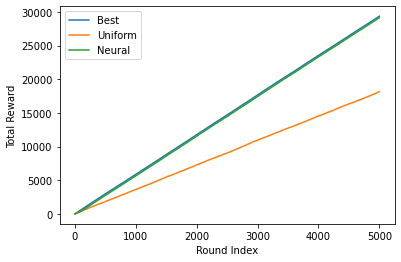

In [4]:
# plot the ratio of cumulated reward
import matplotlib.pyplot as plt
h_r_b = bestagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_b))

h_r_u = uniformagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_u))

h_r_n = deepcopy(neuralagent.history_reward)
plt.plot(range(0, T), np.cumsum(h_r_n))

plt.legend(["Best", "Uniform", "Neural"])
plt.xlabel("Round Index")
plt.ylabel("Total Reward")

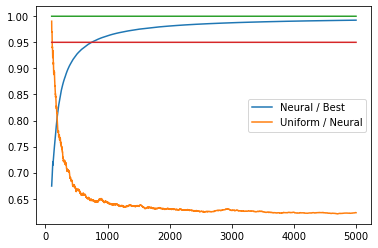

In [5]:
plt.plot(range(100, T), np.cumsum(h_r_n)[100:T] / np.cumsum(h_r_b)[100:T])
plt.plot(range(100, T), np.cumsum(h_r_u)[100:T] / np.cumsum(h_r_n)[100:T])
plt.legend(["Neural / Best", "Uniform / Neural"])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.plot(range(100, T), 0.95 * np.ones(T)[100:T])

Text(0.5, 1.0, 'The ratio of of adopting same decision')

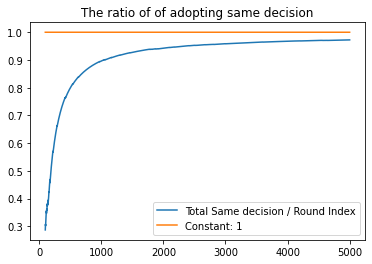

In [6]:
action_match = np.cumsum(neuralagent.history_action == bestagent.history_action)
action_match_ratio = action_match / np.array(range(1, T + 1))
plt.plot(range(100, T), action_match_ratio[100:T])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.legend(["Total Same decision / Round Index", "Constant: 1"])
plt.title("The ratio of of adopting same decision")